# [PageRank](https://en.wikipedia.org/wiki/PageRank) in [Apache Spark](http://spark.apache.org)

This is one of the basic examples how Apache Spark works and how it looks like.

In [1]:
link_data = {
    0: [1, 2],
    1: [2, 6],
    2: [1, 0],
    3: [1, 0],
    4: [1],
    5: [0, 1],
    6: [0, 7],
    7: [0, 1, 2, 3, 9],
    8: [5, 9],
    9: [7]
}

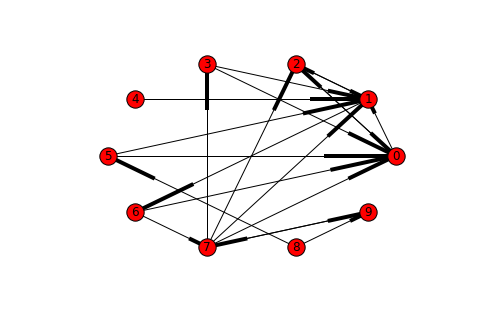

In [2]:
import networkx as nx
link_graph = nx.DiGraph(link_data)
labels = dict((n, str(n)) for n in link_graph.nodes())
nx.draw_circular(link_graph, labels = labels)

In [ ]:
ranks = sc.parallelize(link_data.keys()).map(lambda x : (x, 1.0))

In [ ]:
ranks.collect()

In [ ]:
links = sc.parallelize(link_data.items()).cache()

In [ ]:
links.collect()

In [ ]:
links.join(ranks).collect()

In [ ]:
def computeContribs(node_urls_rank):
    _, (urls, rank) = node_urls_rank
    nb_urls = len(urls)
    for url in urls:
        yield url, rank / nb_urls

This takes a while to execute. Do

    tail -f ~/.smc/jupyter/jupyter-notebook.*
    
in a Terminal to see what's going on behind the scenes!

### Operations

[Transformations](http://spark.apache.org/docs/latest/programming-guide.html#transformations) and [Actions](http://spark.apache.org/docs/latest/programming-guide.html#actions)

In [ ]:
from operator import add

for iteration in range(10):
    # compute contributions of each node where it links to
    contribs = links.join(ranks).flatMap(computeContribs)

    # use a full outer join to make sure, that not well connected nodes aren't dropped
    contribs = links.fullOuterJoin(contribs).mapValues(lambda x : x[1] or 0.0)

    # Sum up all contributions per link
    ranks = contribs.reduceByKey(add)

    # Re-calculate URL ranks
    ranks = ranks.mapValues(lambda rank: rank * 0.85 + 0.15)

# Collects all URL ranks
for (link, rank) in sorted(ranks.collect()):
    print("%s has rank: %s." % (link, rank / len(link_data)))

## Comparison with NetworkX

[DiGraph.pagerank](http://networkx.readthedocs.io/en/latest/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html#networkx.algorithms.link_analysis.pagerank_alg.pagerank)

In [ ]:
import networkx as nx
g = nx.DiGraph(link_data)
nx.pagerank(g)